# Exercise 06 - Spike detection and sorting

## Import data

Import the data relative to E05

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

data = pd.read_csv('../signals/E05_signal.csv').values.squeeze()

px.line(pd.DataFrame(data))

## Detect spikes and determine the number of neurons

In [132]:
from scipy.signal import find_peaks

ths = 0.6
refractory = int(np.round(1e04 * 0.003))

pk_locs = find_peaks(np.abs(data), height=ths, distance=refractory)[0]
print(f'{len(pk_locs)} spikes found.')

spike_matrix = []
for p in pk_locs:
    spike_matrix.append(data[p-refractory:p+refractory])
spike_matrix = np.asarray(spike_matrix)

896 spikes found.


In [133]:
def peak2peak(shape_in):
    return np.ptp(shape_in)
def pos_peak(shape_in):
    return(np.max(shape_in))
def neg_peak(shape_in):
    return np.abs(np.min(shape_in))
def energy(shape_in):
    return np.sqrt(np.sum(shape_in**2))
def l_activation(shape_in):
    samples_active = np.sum(np.abs(shape_in) > 0.1*np.max(np.abs(shape_in)))
    return samples_active/shape_in.size

def extract_features(shape_in, function_list):
    
    feat_out = [f(shape_in) for f in function_list]

    return np.asarray(feat_out)

feature_list = [peak2peak, pos_peak, neg_peak, energy, l_activation]

features_all = []
for i in range(spike_matrix.shape[0]):
    features_all.append(extract_features(spike_matrix[i,:].squeeze(), feature_list))
features_all = np.asarray(features_all)

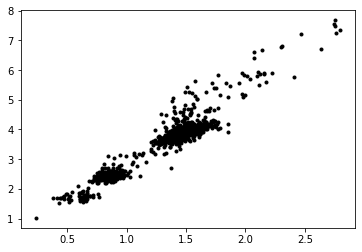

In [134]:
features_to_plot = [1,3]

if len(features_to_plot) > 2:
    fig = px.scatter_3d(
        pd.DataFrame(features_all),
        x=features_to_plot[0],
        y=features_to_plot[1],
        z=features_to_plot[2],
        size_max=1
    )
    fig.show()
elif len(features_to_plot) == 2:
    plt.figure()
    plt.plot(features_all[:,features_to_plot[0]], features_all[:,features_to_plot[1]], 'k.')
    plt.show()
elif len(features_to_plot) == 1:
    plt.figure()
    plt.plot(features_all[:,features_to_plot[0]], 'k.')
    plt.show()

## Sort spikes

In [135]:
from sklearn.cluster import KMeans

n_neurons = 3
cluster = KMeans(n_clusters=n_neurons)

features_to_cluster = [0,3]
cluster.fit(features_all[:,features_to_cluster])

KMeans(n_clusters=3)

## Visualize the quality of the sorting results

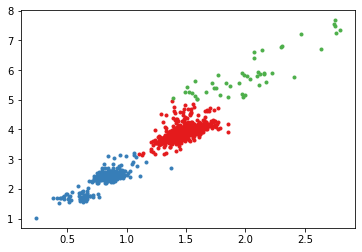

In [136]:
plt.figure()

c = plt.get_cmap('Set1')

for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    plt.plot(features_all[idx,features_to_plot[0]], features_all[idx,features_to_plot[1]], '.', c=c(i))

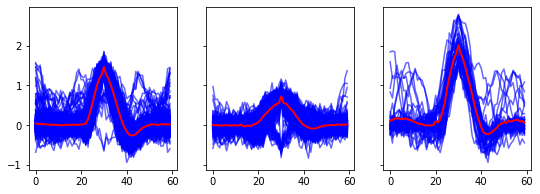

In [137]:
idx = cluster.labels_
fig,ax = plt.subplots(1,n_neurons,figsize=(n_neurons*3,3), sharex=True, sharey=True)
for i in np.unique(idx):
    spikes_neuron = spike_matrix[np.where(idx == i)[0],:]
    ax[i].plot(spikes_neuron.transpose(), 'b', alpha=0.6)
    ax[i].plot(np.mean(spikes_neuron, axis=0), 'r', lw=2)
plt.show(fig)


## Calculate firing rates

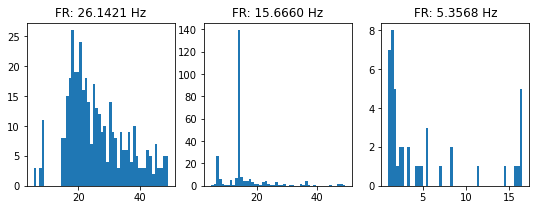

In [138]:
fig,ax = plt.subplots(1,n_neurons,figsize=(n_neurons*3,3))
for i in np.unique(idx):
    firing_instants = pk_locs[np.where(idx==i)[0]]
    firing_rates = (10000)/np.asarray(np.diff(firing_instants))
    firing_rates = firing_rates[np.where(firing_rates < 50)[0]]
    ax[i].hist(firing_rates, bins=50)
    ax[i].set_title(f'FR: {np.mean(firing_rates):.4f} Hz')
plt.show(fig)


## Use a template-based approach to confirm the results

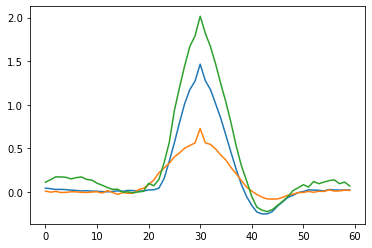

In [139]:
templates_matrix = []
for i in np.unique(idx):
    spikes_cluster = spike_matrix[np.where(idx==i)[0],:]
    templates_matrix.append(np.mean(spikes_cluster,axis=0))
templates_matrix = np.asarray(templates_matrix)

plt.figure()
plt.plot(templates_matrix.transpose())
plt.show()

In [148]:
from scipy.signal import correlate, find_peaks

correlation_all = []
for t in range(templates_matrix.shape[0]):
    tt = templates_matrix[t,:]
    correlation_all.append(correlate(data.reshape(-1,1), tt.reshape(-1,1), mode='same'))
correlation_all = np.asarray(correlation_all).squeeze().transpose()

pks = []
for c in range(correlation_all.shape[1]):
    pks.append(find_peaks(correlation_all[:,c].squeeze(), 
    height=0.5*np.max(correlation_all[:,c]),
    distance=30
    )[0])

from itertools import combinations

n_ambiguous = []
for c in combinations(range(len(pks)),2):
    n_ambiguous.append([c[0], c[1],
    np.sum([x in pks[c[1]] for x in pks[c[0]]]) # First two elements are the template indexes, third element is the number of ambiguous spikes
    ])
print(n_ambiguous)

[[0, 1, 116], [0, 2, 229], [1, 2, 87]]


In [149]:
for i, fi in enumerate(pks):
    isi = np.diff(fi)/1e4
    fr = 1/isi
    print(f'Firing rate for neuron {i}: {np.mean(fr):.4f} Hz')


Firing rate for neuron 0: 19.1193 Hz
Firing rate for neuron 1: 18.6160 Hz
Firing rate for neuron 2: 19.9291 Hz
